### This Notebook Covers CNNs Used To Classify The Extent Of Dementia

The intent of the notebook is as follows:
- Look at the distribution of a particular image before and after normalizing.
- Make use of a SOTA (Densenet) to see if accuracy of the classification improves without a significant time constraint.
- Define and use a custom CNN to see if it performs better/worse.
- Use data augmentation to increase the dataset size and see if accuracies improve further. Also, standardise the data by cetering it in the generator.
- Try to address the fact that medical images tend to have dataleaks and the spilts need to be made carefully in order to not leak the information out into the test set.
- Take a look at the model's predictions and the corresponding maps such as Feature maps, Saliency maps and GRADCAM.

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

In [448]:
img_dir = 'Cropped/0.0/'

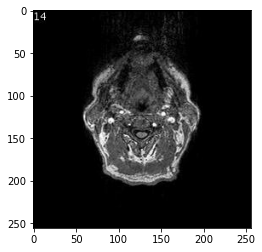

In [449]:
img = plt.imread(os.path.join(img_dir, 'OAS30006_AV45_d2342_m0_t_1.jpg'))
plt.imshow(img, cmap='gray');

In [450]:
img.shape

(256, 256, 3)

In [451]:
# sns.displot(img.ravel());

In [562]:
datagen = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization= True,
    rescale=1./255,
#     width_shift_range=0.07,
#     height_shift_range=0.07,
#     zoom_range=0.5,
    brightness_range=[0,3],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization= True,
    rescale=1./255,
)

In [577]:
#custom CNN params

target_size=64
batch_size = 32

train_gen = datagen.flow_from_directory(
    directory="Cropped/", 
    subset='training',
    class_mode="binary",
    batch_size= batch_size, # images per batch
    shuffle=True, # shuffle the rows or not
    target_size=(target_size,target_size) # width and height of output image
)

val_gen = datagen.flow_from_directory(
    directory="Cropped/", 
    subset='validation',
    class_mode="binary",
    batch_size= batch_size, # images per batch
    shuffle=True, # shuffle the rows or not
    target_size=(target_size,target_size) # width and height of output image
)

test_gen = test_datagen.flow_from_directory(
    directory="test_cnn/", 
    class_mode="binary",
    batch_size= 1, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(target_size,target_size) # width and height of output image
)

Found 2021 images belonging to 2 classes.
Found 504 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


In [564]:
# transfer-learn densenet params
target_sizeD=64
batch_sizeD = 16

train_genD = datagen.flow_from_directory(
    directory="Cropped/", 
    subset='training',
    class_mode="binary",
    batch_size= batch_sizeD, # images per batch
    shuffle=True, # shuffle the rows or not
    target_size=(target_sizeD,target_sizeD) # width and height of output image
)

val_genD = datagen.flow_from_directory(
    directory="Cropped/", 
    subset='validation',
    class_mode="binary",
    batch_size= batch_sizeD, # images per batch
    shuffle=True, # shuffle the rows or not
    target_size=(target_sizeD,target_sizeD) # width and height of output image
)

test_genD = test_datagen.flow_from_directory(
    directory="test_cnn/", 
    class_mode="binary",
    batch_size= 1, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(target_sizeD,target_sizeD) # width and height of output image
)

Found 2021 images belonging to 2 classes.
Found 504 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


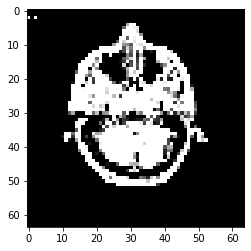

In [578]:
gen_image, label = train_gen.__getitem__(np.random.randint(50))
plt.imshow(gen_image[0], cmap='gray')

In [523]:
gen_image[0].shape

(128, 128, 3)

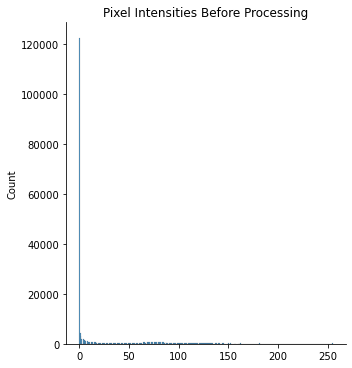

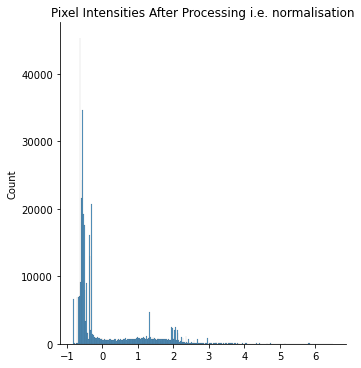

In [457]:
sns.displot(img.ravel())
plt.title('Pixel Intensities Before Processing');

sns.displot(gen_image.ravel())
plt.title('Pixel Intensities After Processing i.e. normalisation');

In [234]:
super_dense = DenseNet121(weights='densenet.hdf5', include_top=False);

In [235]:
super_dense.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['input_7[0][0]']                
 2D)                            3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_12[0][0]']      
                                64)                                                     

                                                                                                  
 conv2_block3_concat (Concatena  (None, None, None,   0          ['conv2_block2_concat[0][0]',    
 te)                            160)                              'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, None, None,   640        ['conv2_block3_concat[0][0]']    
 ization)                       160)                                                              
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, None, None,   0          ['conv2_block4_0_bn[0][0]']      
 n)                             160)                                                              
                                                                                                  
 conv2_blo

 n)                             128)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   16384       ['conv3_block1_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block5_0_relu (Activatio  (None, None, None,   0          ['conv3_block5_0_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv3_block5_1_conv (Conv2D)   (None, None, None,   32768       ['conv3_block5_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block9_0_relu (Activatio  (None, None, None,   0          ['conv3_block9_0_bn[0][0]']      
 n)                             384)                                                              
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, None, None,   49152       ['conv3_block9_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block9_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

                                512)                                                              
                                                                                                  
 pool3_relu (Activation)        (None, None, None,   0           ['pool3_bn[0][0]']               
                                512)                                                              
                                                                                                  
 pool3_conv (Conv2D)            (None, None, None,   131072      ['pool3_relu[0][0]']             
                                256)                                                              
                                                                                                  
 pool3_pool (AveragePooling2D)  (None, None, None,   0           ['pool3_conv[0][0]']             
                                256)                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block4_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_block4_concat (Concatena  (None, None, None,   0          ['conv4_block3_concat[0][0]',    
 te)      

                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block8_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_blo

                                128)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block12_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block12_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block12_1_relu[0][0]']   
                                32)                                                               
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   94208       ['conv4_block16_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block16_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, None, None,   110592      ['conv4_block20_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block20_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block20_1_relu (Activati  (None, None, None,   0          ['conv4_block20_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_blo

 on)                            992)                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, None, None,   126976      ['conv4_block24_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block24_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block3_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block3_concat (Concatena  (None, None, None,   0          ['conv5_block2_concat[0][0]',    
 te)                            608)                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, None, None,   2432       ['conv5_block3_concat[0][0]']    
 ization) 

                                                                                                  
 conv5_block7_1_relu (Activatio  (None, None, None,   0          ['conv5_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block7_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block7_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block7_concat (Concatena  (None, None, None,   0          ['conv5_block6_concat[0][0]',    
 te)                            736)                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 lization)                      128)                                                              
                                                                                                  
 conv5_block11_1_relu (Activati  (None, None, None,   0          ['conv5_block11_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block11_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block11_concat (Concaten  (None, None, None,   0          ['conv5_block10_concat[0][0]',   
 ate)                           864)                              'conv5_block11_2_conv[0][0]']   
          

 conv5_block15_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block15_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block15_1_relu (Activati  (None, None, None,   0          ['conv5_block15_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block15_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block15_concat (Concaten  (None, None, None,   0          ['conv5_block14_concat[0][0]',   
 ate)     

In [236]:
super_dense.layers[-10:]

In [341]:
op = super_dense.output
add_pool_layer = GlobalAveragePooling2D()(op)

In [342]:
preds = Dense(2, activation="softmax")(add_pool_layer)
model = Model(inputs=super_dense.input, outputs=preds)

In [343]:
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

In [ ]:
model.fit(train_genD,
#           steps_per_epoch=500,
          epochs=25,
          validation_data=val_genD,
#           validation_steps=100,
          workers=-1
         )

In [353]:
filenames = test_genD.filenames
n_samples = len(filenames)

In [354]:
predict = model.predict(test_gen,steps = n_samples)

In [355]:
# model.save('cnn.h5')
m = tf.keras.models.load_model('cnn.h5')

In [356]:
m.evaluate(test_genD)

67/67 [==============================] - 8s 45ms/step - loss: 1.8983


1.898250699043274

In [458]:
def plot_acc(history_fcn, epochs):
    '''plots a the change in train vs val accuracy over epochs'''
    plt.title("Train vs Validation accuracy", size=20)
    plt.semilogy(np.arange(1,epochs+1), history_fcn.history["accuracy"], label="train accuracy")
    plt.semilogy(np.arange(1,epochs+1), history_fcn.history["val_accuracy"], label="validation accuracy")
    # plt.axvline(4.5, c="green", linestyle='--', label="overfitting starts")
    plt.xlabel("Epochs")
    plt.ylabel("Log-scaled accuracy")
    plt.xticks(np.arange(1,epochs+1), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_loss(history_fcn, epochs):
    '''plots a the change in train vs val loss over epochs'''
    plt.title("Train vs Validation loss", size=20)
    plt.plot(np.arange(1,epochs+1), history_fcn.history["loss"], label="train loss")
    plt.plot(np.arange(1,epochs+1), history_fcn.history["val_loss"], label="validation loss")
    # plt.axvline(4.5, c="green", linestyle='--', label="overfitting starts")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.xticks(np.arange(1,epochs+1), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [584]:
def cnn_model_setup(no_filters_list, alike_filters=True):
    ''''''
        
    if alike_filters and len(no_filters_list)==1:
        no_filters_list = no_filters_list*5
    elif len(no_filters_list)==5:
        None
    else:
        raise ValueError("Please change alike_filters to False and pass a list of size 3")
    

    dummy_model = tf.keras.models.Sequential()

    dummy_model.add(Conv2D(no_filters_list[0], kernel_size=4, activation='relu', input_shape=(target_size,target_size,3), padding="same", name='conv1'))
#     dummy_model.add(Conv2D(no_filters_list[1], kernel_size=3, activation='relu', padding="same", name='conv2b'))
#     dummy_model.add(MaxPooling2D(2, name='pool2'))
#     dummy_model.add(Conv2D(no_filters_list[2], kernel_size=3, activation='relu', name='conv3'))
#     dummy_model.add(MaxPooling2D(2, name='pool3'))
#     dummy_model.add(Conv2D(no_filters_list[3], kernel_size=3, activation='relu', name='conv4'))
#     dummy_model.add(Conv2D(no_filters_list[4], kernel_size=3, activation='relu', name='conv5'))
    
    dummy_model.add(MaxPooling2D(2, name='pool4'))
    dummy_model.add(Flatten())
    dummy_model.add(Dense(200, name='dense1a', activation="relu"))
#     dummy_model.add(tf.keras.layers.BatchNormalization())
#     dummy_model.add(Dropout(0.4, name='dropout1'))
    dummy_model.add(Dense(200, name='dense2', activation="relu"))
#     dummy_model.add(tf.keras.layers.BatchNormalization())
#     dummy_model.add(Dropout(0.5, name='dropout1'))

    dummy_model.add(Dense(100, name='dense3', activation="relu"))
    dummy_model.add(Dense(1, name='output', activation="sigmoid"))
    
    return(dummy_model)

In [585]:
no_filters=16
filter_list = [16, 30, 60, 100, 150]
model_c = cnn_model_setup(filter_list, alike_filters=False)
print(f"Total # of parameters with # of filters={filter_list} across conv layers is {model_c.count_params()}")

Total # of parameters with # of filters=[16, 30, 60, 100, 150] across conv layers is 3338185


In [586]:
model_c.summary()

Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 16)        784       
                                                                 
 pool4 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 flatten_119 (Flatten)       (None, 16384)             0         
                                                                 
 dense1a (Dense)             (None, 200)               3277000   
                                                                 
 dense2 (Dense)              (None, 200)               40200     
                                                                 
 dense3 (Dense)              (None, 100)               20100     
                                                                 
 output (Dense)              (None, 1)              

Epoch 1/5
64/64 [==============================] - 24s 252ms/step - loss: 0.8291 - accuracy: 0.5161 - val_loss: 0.7148 - val_accuracy: 0.5556
Epoch 2/5
64/64 [==============================] - 16s 249ms/step - loss: 0.6588 - accuracy: 0.6066 - val_loss: 0.7217 - val_accuracy: 0.5714
Epoch 3/5
64/64 [==============================] - 18s 277ms/step - loss: 0.6061 - accuracy: 0.6670 - val_loss: 0.7403 - val_accuracy: 0.5258
Epoch 4/5
64/64 [==============================] - 58s 907ms/step - loss: 0.5368 - accuracy: 0.7279 - val_loss: 0.7489 - val_accuracy: 0.5317
Epoch 5/5
64/64 [==============================] - 41s 637ms/step - loss: 0.4784 - accuracy: 0.7674 - val_loss: 0.8306 - val_accuracy: 0.5456


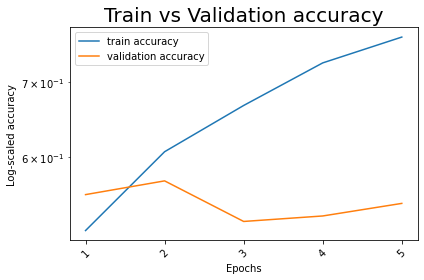

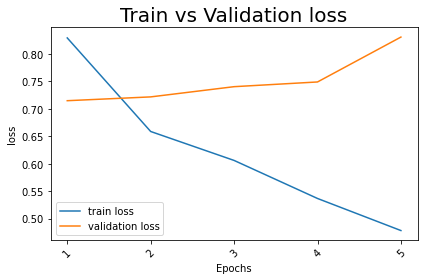

In [588]:
epochs = 5
model = cnn_model_setup([16, 30, 60, 100, 120], alike_filters=False)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
history_cnn = model.fit(train_gen, epochs=epochs, validation_data=val_gen, workers=-1)
# train_acc.append(history.history['val'])
plot_acc(history_cnn, epochs)
plot_loss(history_cnn, epochs)

In [468]:
# model.evaluate(test_gen)

131/131 [==============================] - 1s 9ms/step - loss: 1.3491 - accuracy: 0.6565


[1.3490614891052246, 0.6564885377883911]

In [590]:
model.evaluate(test_gen)

131/131 [==============================] - 3s 15ms/step - loss: 0.6758 - accuracy: 0.6412


[0.6758489012718201, 0.6412213444709778]

### Now that our model is ready, let's take a look at a set of feature maps for an image

In [293]:
prediction = np.argmax(model.predict(gen_image[0][np.newaxis,:,:,:]/255.))

In [298]:
feat_map = Model(inputs=model.input, outputs=model.layers[1].output)

In [299]:
f_map = feat_map.predict(gen_image[0][np.newaxis,:,:,:]/255.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


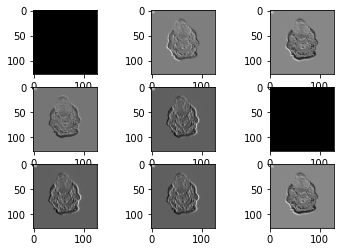

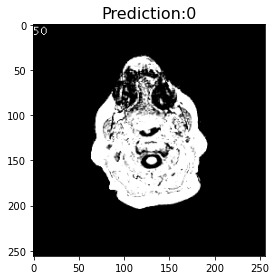

In [300]:
plt.close('all')
fig, ax = plt.subplots(3,3)
axis = ax.ravel()

true_img_ax = plt.figure().add_subplot(1,1,1)
true_img_ax.set_title(f"Prediction:{prediction}", size=16)
true_img_ax.imshow(gen_image[0])

filters_9 = np.random.randint(0,f_map.shape[3],9)
for i, fil_ind in enumerate(filters_9):
    axis[i].imshow(f_map.squeeze()[:,:,fil_ind], cmap='gray')

plt.tight_layout()

In [316]:
np.array([0]).reshape(-1,1).astype(int)[0][0]

0

In [310]:
gen_image[0].shape, np.array([0]).reshape(-1,1).shape

((256, 256, 3), (1, 1))

### Define a method to plot maps

In [338]:
def cam_plots(img):
    replace2linear = ReplaceToLinear()
    score =  CategoricalScore(np.array([0]).reshape(-1,1)[0][0].astype(int))


    saliency = Saliency(model,
                        model_modifier=replace2linear,
                        clone=True)

    # Generate saliency map
    saliency_map = saliency(score, img[np.newaxis,:,:,:]/255.,smooth_samples=20, smooth_noise=0.20)


    # Create Gradcam object
    gradcam = Gradcam(model,
                      model_modifier=replace2linear,
                      clone=True)

    # Generate heatmap with GradCAM
    cam = gradcam(score,
                  img/255.,
                  penultimate_layer=-1)


    # Render
    heatmap = np.uint8(cm.viridis(cam[0])[..., :3] * 255)

    list_maps = [img, saliency_map[0], heatmap]
    image_titles = ["Original", "Saliency", "GradCAM"]

    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(img/255.)
        ax[i].imshow(list_maps[i], cmap='viridis')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

#### Let's now take a look at a train image and its maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


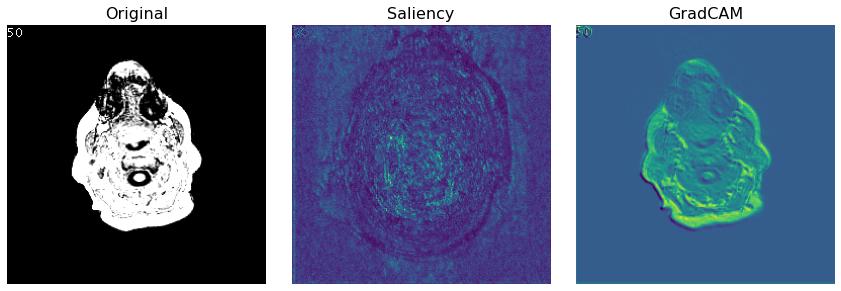

In [339]:
cam_plots(gen_image[0])

#### Test image and its maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


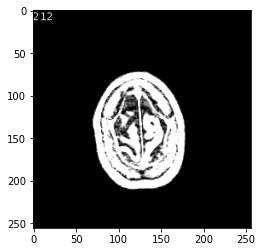

In [322]:
test_image, label = test_gen.__getitem__(np.random.randint(50))
plt.imshow(test_image[0], cmap='gray');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


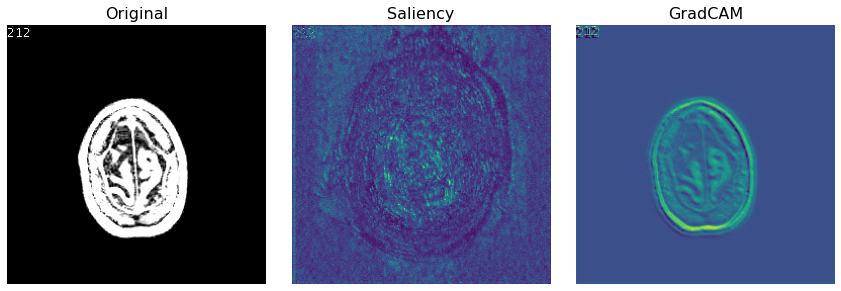

In [333]:
cam_plots(test_image[0])

### What we learnt from a ~2.5k imbalanced dataset of images:

- Normalising the data does help in inflating the distributions to make it more meaningful and can be seen as a good approach to follow.
- The accuracies wouldn't match a production level system as:
    - The images in the dataset have a spatial ordering across images i.e. patient1-image1 is the lower part of the brain while patient1-image4 is of the top half of the brain which deprives the model of that sequential learning. A stronger model would be built by stitching together all images of a patient into one with slight pertutbations and then doing a fit on them.
    - More compute would be needed to capture intricate details, we're down-sizing to 64x64
- The SOTA model took a long time to run relatively, didn't really improve the metric of interest significantly. We still do think that unfreezing more layers instead of just a GAP layer addition could also help.
- The GRADCAM does a good job at highlighting the region of interest for both, the sample test and, the train image.
- We also suspect that due such large amounts of variations in the data even augmentation wouldn't particularly be of help.
- We also haven't been able to specifically address class imbalance, which would single-handedly derail the accuracy metric. The future work would also involve taking the images and extensively preprocessing them to be axis aligned. We've mapped the problem to be a binary one 0.0-> non-demented; [0.5,1.0, 2.0, 3.0]->demented.